## Simulate non-isoplanatic imaging for LOW at 100MHz.

### A set of model components are drawn from GLEAM. An ionospheric screen model is used to calculate the pierce points of the two stations in an interferometer for a given component. The model visibilities are calculated directly, and screen phase applied to obtain the corrupted visibility.

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents, partition_skycomponent_neighbours

from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions, \
    calculate_sf_from_screen
from wrappers.serial.skymodel.operations import show_skymodel

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.arlexecute.skymodel.skymodel_arlexecute import predictcal_skymodel_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import export_blockvisibility_to_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client



In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
c = get_dask_Client(
    memory_limit=64 * 1024 * 1024 * 1024, n_workers=16, threads_per_worker=1)
arlexecute.set_client(c)
# Initialise logging on the workers. This appears to only work using the process scheduler.
arlexecute.run(init_logging)

Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:8787


{'tcp://127.0.0.1:32833': None,
 'tcp://127.0.0.1:33355': None,
 'tcp://127.0.0.1:33833': None,
 'tcp://127.0.0.1:34227': None,
 'tcp://127.0.0.1:35891': None,
 'tcp://127.0.0.1:37109': None,
 'tcp://127.0.0.1:39485': None,
 'tcp://127.0.0.1:39835': None,
 'tcp://127.0.0.1:40271': None,
 'tcp://127.0.0.1:41343': None,
 'tcp://127.0.0.1:42035': None,
 'tcp://127.0.0.1:43781': None,
 'tcp://127.0.0.1:44013': None,
 'tcp://127.0.0.1:44029': None,
 'tcp://127.0.0.1:44251': None,
 'tcp://127.0.0.1:46311': None}

### Set up the observation: 10 minutes at transit, with 10s integration.

In [5]:
nfreqwin = 1
ntimes = 61
rmax = 10000.0
dec = -55.0 * u.deg
frequency = numpy.linspace(1e8, 1.3e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.3e8]
times = numpy.linspace(-300, 300.0, ntimes) * numpy.pi / (3600.0 * 12.0)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=dec, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

blockvis = create_blockvisibility(
    lowcore,
    times,
    frequency=frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"),
    zerow=True)

### Find sampling, image size, etc

In [6]:
wprojection_planes = 1
vis = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']
if npixel > 1024:
    deconvolve_facets = 8
    deconvolve_overlap = 32
    deconvolve_taper = 'tukey'
else:
    deconvolve_facets = 1
    deconvolve_overlap = 0
    deconvolve_taper = 'tukey'

### Generate the model from the GLEAM catalog, including application of the primary beam.

Number of bright components 8
Number of components 270


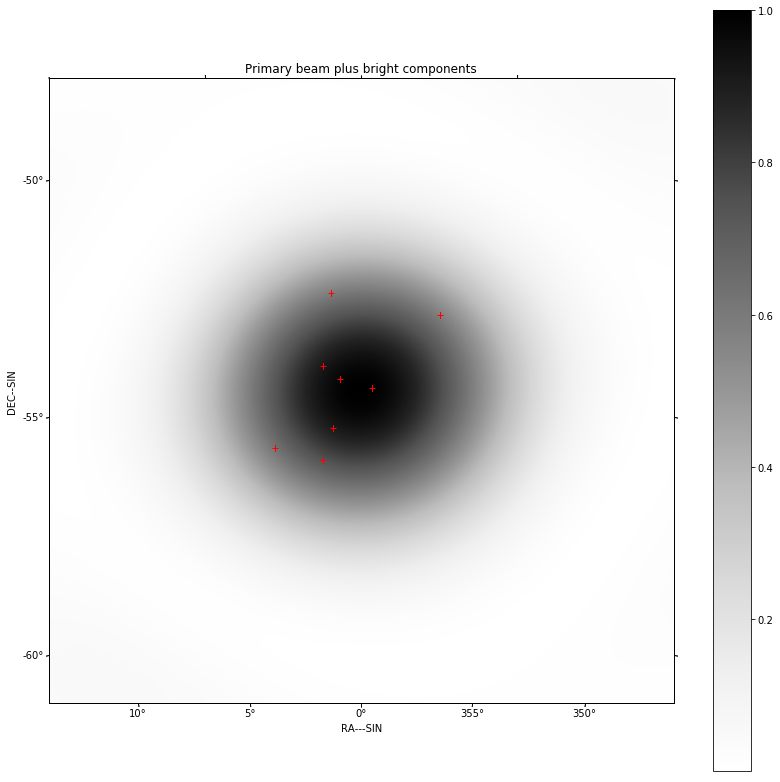

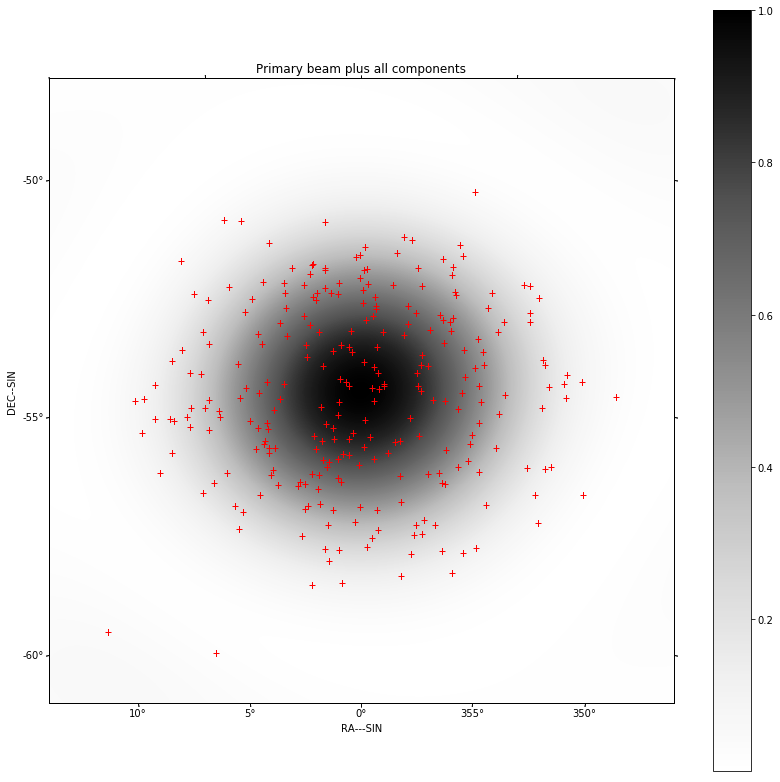

In [7]:
flux_limit=0.1
dft_threshold = 2.0
beam = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
beam = create_low_test_beam(beam)

original_gleam_components = create_low_test_skycomponents_from_gleam(
    flux_limit=flux_limit,
    phasecentre=phasecentre,
    frequency=frequency,
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=0.2)

all_components = apply_beam_to_skycomponent(original_gleam_components,
                                                 beam)

all_components = filter_skycomponents_by_flux(
    all_components, flux_min=flux_limit)

bright_components = filter_skycomponents_by_flux(
    all_components, flux_min=dft_threshold)
weak_components = filter_skycomponents_by_flux(
    all_components, flux_min=flux_limit, flux_max=dft_threshold)

show_image(
    beam,
    components=bright_components,
    cm='Greys',
    title='Primary beam plus bright components')

lprint("Number of bright components %d" % len(bright_components))
show_image(
    beam,
    components=all_components,
    cm='Greys',
    title='Primary beam plus all components')

lprint("Number of components %d" % len(all_components))

### Insert weak components in images

In [8]:
model = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)

def insert_components(im, comps):
    imcomps = copy_image(im)
    return insert_skycomponent(imcomps, comps)

comps_lists = partition_skycomponent_neighbours(weak_components, bright_components)
weak_images = [insert_components(model, comps) for comps in comps_lists]

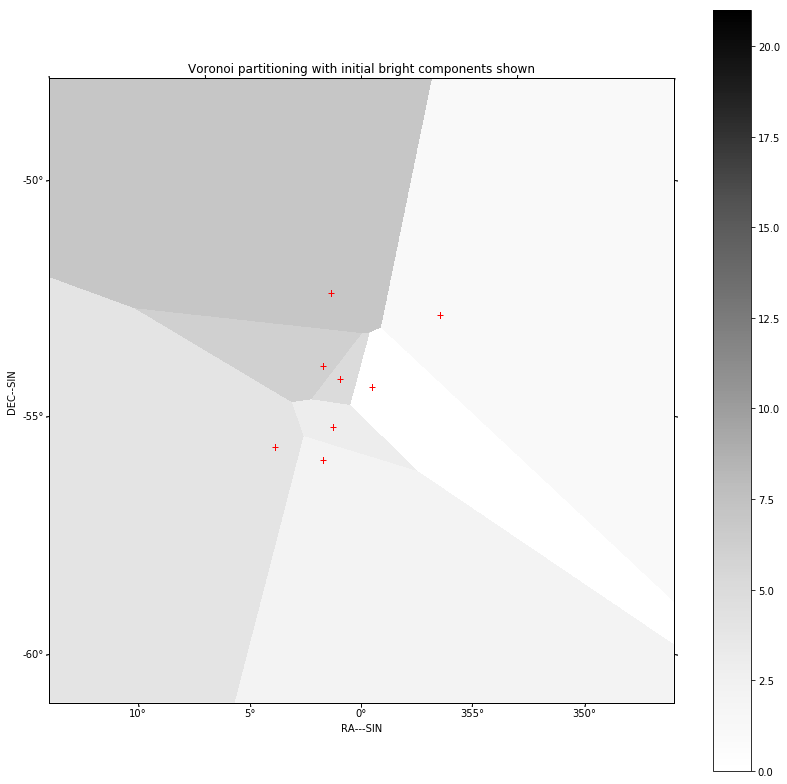

In [9]:
from processing_components.skycomponent.operations import voronoi_decomposition
vor, vor_array = voronoi_decomposition(model, bright_components)
vor_image = copy_image(model)
vor_image.data[...] = vor_array

show_image(
    vor_image,
    cm='Greys',
    title='Voronoi partitioning with initial bright components shown',
    components=bright_components,
    vmax = 3 * numpy.max(vor_array))

plt.show()



### Fill the gaintables from the ionospheric screen model

In [10]:
screen = import_image_from_fits('low_screen_5000.0r0_0.100rate.fits')
gaintables = create_gaintable_from_screen(blockvis, bright_components, screen, scale=3.0)

Image:
	Shape: (1, 1, 1000, 1000)
	WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'XX'  'YY'  'TIME'  'FREQ'  
CRVAL : 0.0  0.0  0.0  100000000.0  
CRPIX : 501.0  501.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : 100.0  100.0  10.0  10000000.0  
NAXIS : 2000  2000  61  1
	Polarisation frame: stokesI



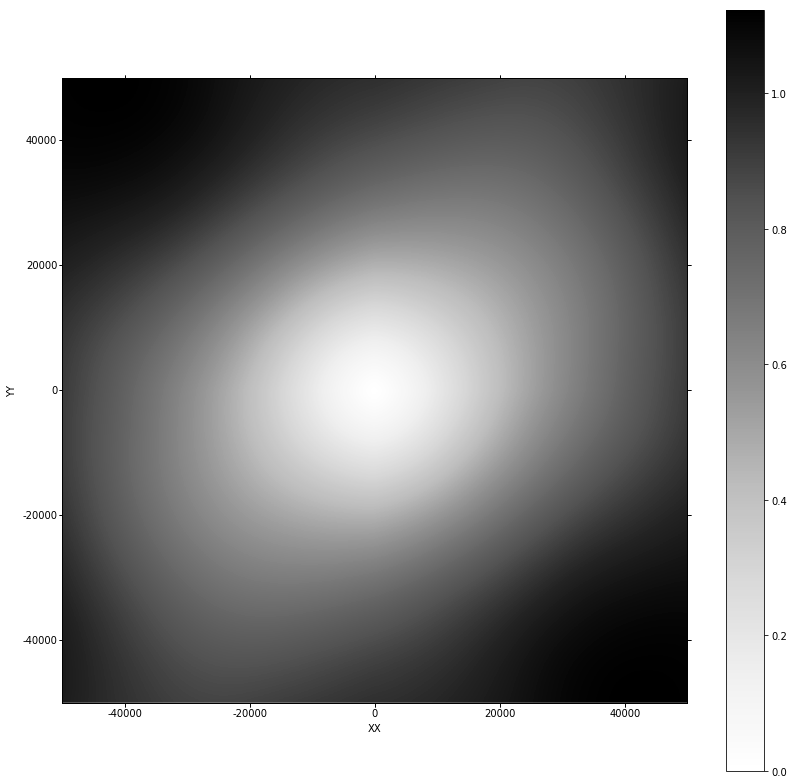

In [11]:
sf = calculate_sf_from_screen(screen)
print(sf)
show_image(sf)
plt.show()
export_image_to_fits(sf, 'low-sims-structure_function_rmax%.1f.hdf5' % rmax)